In [87]:
import sqlite3
import json

import pandas as pd
import numpy as np
from geopy.distance import distance as geodist

In [2]:
conn = sqlite3.connect('breath.db')
cursor = conn.cursor()

In [3]:
data = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

table_names = []

for i in data.fetchall():
    if i[0] != "sqlite_sequence":
        table_names.append(i[0])

table_names

['Sintomas', 'Cidades', 'Estacoes', 'Clima', 'SRAG', 'Estacao_Cidade']

In [4]:
table_columns = {}

for name in table_names:
    data = cursor.execute("SELECT * FROM {0}".format(name))
    table_columns[name] = []

    for column in data.description:
        table_columns[name].append(column[0])

In [5]:
table_schemas = {}

for name in table_columns:
    schema = name+"("

    for column in table_columns[name]:
        schema += column + ", "
    schema += ")"

    table_schemas[name] = schema

In [6]:
for name in table_schemas:
    print(table_schemas[name])
    print()

Sintomas(Id, Tipo, Ano, Mês, Dia, Cidade, )

Cidades(Id, UF, Nome_UF, Mesorregiao_geografica, Nome_mesorregiao, Microrregiao_geografica, Nome_Microrregiao, Municipio, Cod_municipio, Nome_municipio, lat, lon, )

Estacoes(Id, Estacao, Regiao, UF, Codigo, Prim_data, alt, lon, lat, )

Clima(id, date, station, precipitacao, pressao_at_max, pressao_at_min, radiacao, temp_max, temp_min, umidade, max_vent, velocidade_vent, region, state, lat, lon, elvt, )

SRAG(id, DT_NOTIFIC, ID_MUNICIP, SEM_NOT, SG_UF_NOT, DT_SIN_PRI, DT_NASC, NU_IDADE_N, CS_SEXO, CS_GESTANT, CS_RACA, CS_ESCOL_N, SG_UF, ID_MN_RESI, ID_OCUPA_N, VACINA, FEBRE, TOSSE, CALAFRIO, DISPNEIA, GARGANTA, ARTRALGIA, MIALGIA, CONJUNTIV, CORIZA, DIARREIA, OUTRO_SIN, OUTRO_DES, CARDIOPATI, PNEUMOPATI, RENAL, HEMOGLOBI, IMUNODEPRE, TABAGISMO, METABOLICA, OUT_MORBI, MORB_DESC, HOSPITAL, DT_INTERNA, CO_UF_INTE, CO_MU_INTE, DT_PCR, PCR_AMOSTR, PCR_OUT, PCR_RES, PCR_ETIOL, PCR_TIPO_H, PCR_TIPO_N, DT_CULTURA, CULT_AMOST, CULT_OUT, CULT_RES, DT_

In [10]:
# Carrega e salva posições e nomes das estações climáticas e cidades

data = cursor.execute("SELECT lat, lon FROM Estacoes")
data = data.fetchall()
pos_estacoes = data 

data = cursor.execute("SELECT Estacao FROM Estacoes")
data = data.fetchall()
nome_estacoes = np.asarray(data).flatten()

data = cursor.execute("SELECT Id FROM Estacoes")
data = data.fetchall()
id_estacoes = np.asarray(data).flatten()

data = cursor.execute("SELECT lat, lon FROM Cidades")
data = data.fetchall()
pos_cidades = data

data = cursor.execute("SELECT Nome_municipio FROM Cidades")
data = data.fetchall()
nome_cidades = np.asarray(data).flatten()

data = cursor.execute("SELECT Id FROM Cidades")
data = data.fetchall()
id_cidades = np.asarray(data).flatten()

In [11]:
# Cria tabela que relaciona estações climáticas com cidades

query = "CREATE TABLE IF NOT EXISTS Estacao_Cidade(Id_Cidade INTEGER, Id_Estacao INTEGER, "
query += "FOREIGN KEY (Id_Cidade) REFERENCES Cidades(Id), FOREIGN KEY (Id_Estacao) REFERENCES Estacoes(Id)"
query += ")"
cursor.execute(query)

In [12]:
# Procura as estações climáticas mais próximas (distancia < 25 km)

for i in range(len(pos_cidades)):

    distances = np.ndarray(len(pos_estacoes), np.float32)

    for j in range(len(pos_estacoes)):
        distances[j] = geodist(pos_cidades[i], pos_estacoes[j]).km

    indexes = np.argwhere(distances < 25.0).flatten()

    id_cidade_to_insert = id_cidades[i]
    id_estacoes_to_insert = id_estacoes[indexes]

    for id_estacao in id_estacoes_to_insert:
        query = "INSERT INTO Estacao_Cidade(Id_Cidade, Id_Estacao) VALUES('{0}', '{1}')".format(id_cidade_to_insert, id_estacao)
        cursor.execute(query)

In [13]:
conn.commit()

In [236]:
# Cria view com dia desde a epoch para a tabela de dados climáticos

query = "CREATE VIEW IF NOT EXISTS Clima_Data  AS SELECT *, "
query += "(strftime('%s', substr(DT_NOTIFIC, 7, 8) ||'-'|| substr(substr(DT_NOTIFIC, 4, 6),1,2) ||'-'|| substr(DT_NOTIFIC, 1, 2) )/86400) AS DIA "
query += "FROM Clima"

cursor.execute(query)

In [235]:
# Cria view com dia desde epoch para a tabela de dados de sintoma

query = "CREATE VIEW IF NOT EXISTS SRAG_Data AS SELECT *, "
query += "(strftime('%s', substr(DT_NOTIFIC, 7, 8) ||'-'|| substr(substr(DT_NOTIFIC, 4, 6),1,2) ||'-'|| substr(DT_NOTIFIC, 1, 2) )/86400) AS DIA "
query += "FROM SRAG"


cursor.execute(query)

In [224]:
# Solicita os dados climáticos por dia, agregando com média

# Gera o condicional com os nomes das estações
station_conditional = "("
for nome in nomes:
    station_conditional += "station='{0}' OR ".format(nome)
station_conditional = station_conditional[:-4]+")"

climate_query = "SELECT DIA, Avg(precipitacao), Avg(pressao_at_max), Avg(pressao_at_min), Avg(radiacao), Avg(temp_max), Avg(temp_min), Avg(umidade), Avg(max_vent), Avg(velocidade_vent) "
climate_query += "FROM Clima_Data WHERE {0}  GROUP BY DIA ORDER BY DIA".format(station_conditional)

data = cursor.execute(climate_query)
data = data.fetchall()
data

[(13354, 0.0, 926.05, 925.59, 0.0, 27.9, 22.2, 49.7, 7.2, 1.7600000000000002),
 (13355,
  0.4,
  925.5750000000004,
  925.1166666666668,
  0.0,
  27.5,
  15.6,
  64.33333333333333,
  10.1,
  1.6208333333333331),
 (13356,
  0.0,
  925.4125,
  924.9916666666668,
  0.0,
  28.2,
  14.4,
  61.375,
  8.4,
  1.5458333333333334),
 (13357,
  0.0,
  924.9291666666668,
  924.5166666666664,
  0.0,
  29.4,
  17.5,
  69.70833333333333,
  9.1,
  1.6666666666666667),
 (13358,
  0.6,
  922.6333333333332,
  922.1333333333332,
  0.0,
  24.8,
  19.1,
  70.66666666666667,
  11.5,
  2.45),
 (13361,
  0.0,
  933.5666666666668,
  933.1555555555556,
  269.6666666666667,
  15.2,
  13.2,
  97.11111111111111,
  4.1,
  1.3111111111111111),
 (13362,
  0.0,
  932.7571428571428,
  932.2571428571428,
  216.7142857142857,
  15.4,
  14.2,
  97.71428571428572,
  5.4,
  2.2142857142857144),
 (13363,
  0.0,
  931.4333333333332,
  930.8666666666668,
  728.9166666666666,
  19.8,
  13.4,
  88.66666666666667,
  5.9,
  2.333333

In [52]:
# Cria view de casos por cidade e dia

query = "CREATE VIEW IF NOT EXISTS Casos_Dia AS "
query += "SELECT ID_MUNICIP, DIA, Count(*) AS Casos FROM SRAG_Data "
query += "WHERE  FEBRE='1.0' OR TOSSE='1.0' OR GARGANTA='1.0' "
query += "GROUP BY DIA, ID_MUNICIP"
cursor.execute(query)

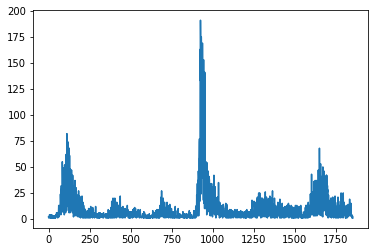

In [243]:
from matplotlib import pyplot as plt

plt.plot(data)

In [21]:
data = cursor.execute("PRAGMA table_info(Clima_Cidade)")
data = data.fetchall()
data

[(0, 'Nome_municipio', 'TEXT', 0, None, 0),
 (1, 'DIA', '', 0, None, 0),
 (2, 'Avg(precipitacao)', '', 0, None, 0),
 (3, 'Avg(pressao_at_max)', '', 0, None, 0),
 (4, 'Avg(pressao_at_min)', '', 0, None, 0),
 (5, 'Avg(radiacao)', '', 0, None, 0),
 (6, 'Avg(temp_max)', '', 0, None, 0),
 (7, 'Avg(temp_min)', '', 0, None, 0),
 (8, 'Avg(umidade)', '', 0, None, 0),
 (9, 'Avg(max_vent)', '', 0, None, 0),
 (10, 'Avg(velocidade_vent)', '', 0, None, 0)]

In [64]:
# View com o clima e as cidades

query = "CREATE VIEW IF NOT EXISTS Clima_Cidade AS " 
query += "SELECT Nome_municipio, Clima_Data.DIA, Avg(precipitacao), Avg(pressao_at_max), Avg(pressao_at_min), Avg(radiacao), Avg(temp_max), Avg(temp_min), Avg(umidade), Avg(max_vent), Avg(velocidade_vent) "
query += "FROM Cidades, Estacao_Cidade, Estacoes, Clima_Data " 
query += "WHERE Estacao_Cidade.Id_Cidade=Cidades.Id AND Estacoes.Id = Estacao_Cidade.Id_Estacao AND Estacoes.Estacao = Clima_Data.station "
query += "GROUP BY Nome_municipio, DIA"

cursor.execute(query)
conn.commit()

In [74]:
# Cria tabela final que relaciona o clima com os casos

query = "CREATE VIEW IF NOT EXISTS Clima_Casos AS SELECT * FROM Clima_Cidade, Casos_Dia WHERE Clima_Cidade.Nome_municipio = Casos_Dia.ID_MUNICIP AND Clima_Cidade.DIA = Casos_Dia.DIA ORDER BY Nome_municipio, DIA"
data = cursor.execute(query)
data = data.fetchall()

conn.commit()

In [75]:
# Solicita todos os dados

data_execution = cursor.execute("SELECT * FROM Clima_Casos")
data = data_execution.fetchall()

final_data = data

In [84]:
# Pega a sequência das colunas

final_column_names = []

for column in data_execution.description:
    final_column_names.append(column[0])

final_column_names

['Nome_municipio',
 'DIA',
 'Avg(precipitacao)',
 'Avg(pressao_at_max)',
 'Avg(pressao_at_min)',
 'Avg(radiacao)',
 'Avg(temp_max)',
 'Avg(temp_min)',
 'Avg(umidade)',
 'Avg(max_vent)',
 'Avg(velocidade_vent)',
 'ID_MUNICIP',
 'DIA:1',
 'Casos']

In [89]:
# Pega a quantidade de dados por cidade

data = cursor.execute("SELECT Nome_municipio, COUNT(*) FROM Clima_Casos GROUP BY Nome_municipio")
data = data.fetchall()

In [133]:
data

[('Agrolândia', 1),
 ('Agudos', 12),
 ('Alcobaça', 2),
 ('Alfredo Chaves', 2),
 ('Alta Floresta', 14),
 ('Altamira', 27),
 ('Alto Alegre', 5),
 ('Alvorada', 25),
 ('Além Paraíba', 3),
 ('Amambai', 13),
 ('Ametista do Sul', 1),
 ('Amorinópolis', 3),
 ('Ananindeua', 69),
 ('Anchieta', 4),
 ('Angra dos Reis', 33),
 ('Antonina', 1),
 ('Aparecida', 23),
 ('Aparecida de Goiânia', 134),
 ('Apuí', 2),
 ('Aquidauana', 74),
 ('Aquiraz', 3),
 ('Aracaju', 153),
 ('Aracati', 13),
 ('Aragarças', 1),
 ('Araguaína', 23),
 ('Arapiraca', 1),
 ('Araporã', 3),
 ('Araranguá', 165),
 ('Araucária', 55),
 ('Araxá', 93),
 ('Arcos', 1),
 ('Arcoverde', 5),
 ('Ariquemes', 8),
 ('Arroio do Meio', 7),
 ('Atibaia', 34),
 ('Avaré', 84),
 ('Bagé', 103),
 ('Baixo Guandu', 5),
 ('Balneário Camboriú', 264),
 ('Balsas', 2),
 ('Bambuí', 3),
 ('Bandeirantes', 14),
 ('Barbacena', 157),
 ('Barbalha', 14),
 ('Barcarena', 71),
 ('Barra', 7),
 ('Barra Bonita', 8),
 ('Barra Mansa', 6),
 ('Barra de São Francisco', 9),
 ('Barra do 

In [137]:
final_dataframe = pd.DataFrame(final_data, columns = final_column_names)

final_dataframe.describe()

,DIA,Avg(precipitacao),Avg(pressao_at_max),Avg(pressao_at_min),Avg(radiacao),Avg(temp_max),Avg(temp_min),Avg(umidade),Avg(max_vent),Avg(velocidade_vent),DIA:1,Casos
count,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000,52846.000000
mean,16906.517560,2.068562,966.042811,965.476802,1250.112389,27.007618,17.546936,66.494294,8.336151,2.224942,16906.517560,2.563449
std,651.930055,6.974055,42.504852,42.495247,489.829689,5.056203,4.718221,14.350800,2.805522,1.175520,651.930055,4.600248
min,15707.000000,0.000000,833.375595,831.866071,0.000000,5.000000,-3.200000,16.750000,0.000000,0.000000,15707.000000,1.000000
25%,16288.000000,0.000000,929.040417,928.500000,936.942308,23.900000,14.500000,57.428571,6.500000,1.472727,16288.000000,1.000000
50%,16957.000000,0.000000,962.487121,961.891288,1306.307692,27.800000,17.900000,67.333333,8.000000,2.036364,16957.000000,1.000000
75%,17490.000000,0.200000,1009.467803,1008.900000,1595.798077,30.800000,21.100000,76.571429,9.800000,2.775000,17490.000000,2.000000
max,18011.000000,208.200000,1033.290909,1032.754545,3747.000000,41.400000,34.700000,100.000000,78.700000,18.216667,18011.000000,191.000000


In [232]:
cursor.execute("SELECT COUNT(*) FROM Clima").fetchall()

[(2134880,)]

In [144]:
np.savez("dataset_pandas.npz", final_dataframe)